## **Network Intrusion Detection via Anomaly Detection**

# Project Overview

**Objective**: Develop a robust machine learning pipeline to detect "Zero-Day" network attacks using unsupervised learning.

**Dataset Definition (NSL-KDD)**: > The NSL-KDD dataset is the industry standard for evaluating intrusion detection systems. It is a refined version of the original KDD’99 set. We chose this because:



1. **No Redundancy**: It removes duplicate records that would otherwise bias the model toward frequent normal traffic.

2. **Balanced Complexity**: It includes difficulty levels that force the model to learn subtle patterns of attack, making the evaluation more realistic.

3. **Binary & Multi-class labels**: Allows us to evaluate both "Is this an attack?" (Binary) and "What kind of attack is it?" (Multi-class).

**Additional Notes:**

**Production & MLOps Considerations (AWS Focus)**

- **Scalability**: For real-time threat detection, this model is designed to be deployed as an Amazon SageMaker Real-Time Endpoint. For historical audit logs, it can be triggered as a SageMaker Batch Transform job.

- **Model Monitoring**: Using Amazon CloudWatch, we track the 'Reconstruction Error' of the Autoencoder. If the average error increases over time without a corresponding attack, it signals Model Drift, triggering an automated retraining pipeline via AWS Step Functions.

- **Security & Compliance**: Given the sensitivity of network logs, the architecture follows Least Privilege IAM roles. All data in transit is encrypted using TLS 1.2+, and data at rest in S3 is encrypted via AWS KMS.

In [7]:
# Global Imports & Environment Setup

# Standard Library Imports
import os

# Data Handling & Analytics
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning (Scikit-Learn)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Utilities & AWS Preparation
import kagglehub
import joblib
import tarfile

print("Libraries imported successfully.")

Libraries imported successfully.


## **Data Ingestion**

In [23]:
path = kagglehub.dataset_download("hassan06/nslkdd")

print("Path to dataset files:", path)

#  Check what files are in the downloaded path
print(f"Files in Kaggle path: {os.listdir(path)}")

#  Identify the training and testing files (Adjust filenames if they differ slightly)
# Usually, they are named 'KDDTrain+.txt' and 'KDDTest+.txt'
train_path = os.path.join(path, 'KDDTrain+.txt')
test_path = os.path.join(path, 'KDDTest+.txt')

# Define the column names (same as before)
columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
           "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations",
           "num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count",
           "serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate",
           "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
           "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
           "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack","difficulty_level"]

#  Load the DataFrames
train_df = pd.read_csv(train_path, names=columns)
test_df = pd.read_csv(test_path, names=columns)

print(f"Success! Loaded {len(train_df)} training rows and {len(test_df)} testing rows.")


Using Colab cache for faster access to the 'nslkdd' dataset.
Path to dataset files: /kaggle/input/nslkdd
Files in Kaggle path: ['KDDTest+.arff', 'KDDTest-21.arff', 'KDDTest1.jpg', 'KDDTrain+.txt', 'KDDTrain+_20Percent.txt', 'KDDTest-21.txt', 'KDDTest+.txt', 'KDDTrain+.arff', 'index.html', 'nsl-kdd', 'KDDTrain+_20Percent.arff', 'KDDTrain1.jpg']
Success! Loaded 125973 training rows and 22544 testing rows.


## **Exploratory Data Analysis**

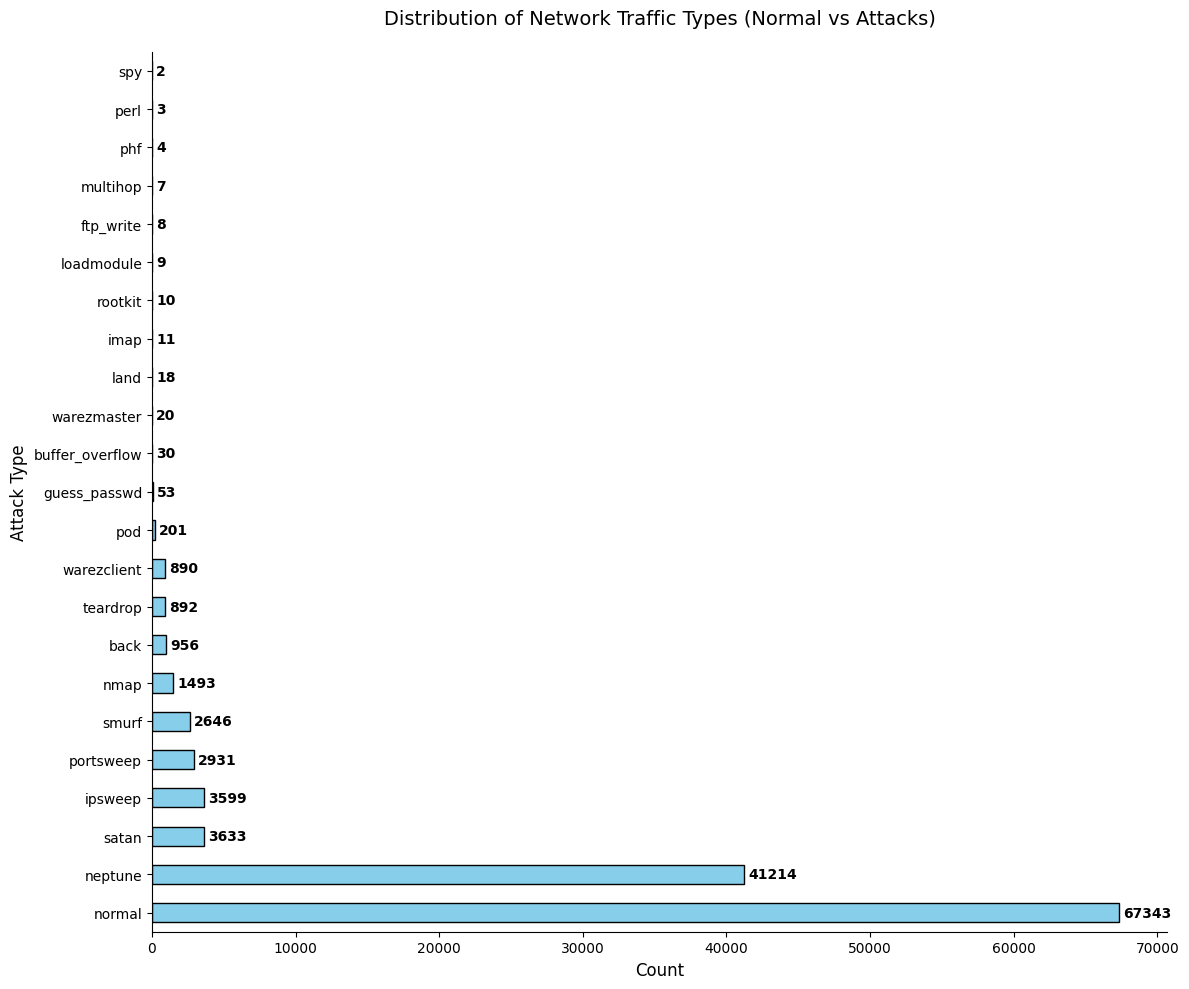

In [25]:
# Attack Type Distribution
plt.figure(figsize=(12, 10))

# Plot
# We use 'barh' for better readability of the various attack names
ax = train_df['attack'].value_counts().plot(kind='barh', color='skyblue', edgecolor='black')

# Titles and labels
plt.title('Distribution of Network Traffic Types (Normal vs Attacks)', fontsize=14, pad=20)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Attack Type', fontsize=12)
ax.bar_label(ax.containers[0], padding=3, fontsize=10, fontweight='bold')

# Clean-up
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### Data Distribution Analysis
**Observations:**
* **Class Balance:** The dataset shows a significant volume of attack traffic (approx. 46.5%) relative to normal traffic. This is higher than typical production networks (where attacks are <1%) but excellent for training because it provides the model with ample "threat" examples to learn from. Calculated Ratio: In the standard NSL-KDD training set, there are 67,343 "normal" records and 58,630 "attack" records.

* **Implication for Modeling:** While we have balanced classes, we will still treat this as an **Anomaly Detection** problem (unsupervised) rather than standard classification. This ensures our model remains robust against "Zero-Day" attacks that don't match these specific labeled categories.

# **Feature Engineering and Data Preprocessing**

**Note on Encoding Strategy:**

In this pipeline, we utilize Label Encoding for categorical features (like protocol_type and service).

 - Production Consideration: For strict Deep Learning production environments, One-Hot Encoding is often preferred. This is because Label Encoding assigns integers (e.g., TCP=1, UDP=2), which a Neural Network might misinterpret as an ordinal relationship (implying UDP > TCP).

- Current Choice: We use Label Encoding here to maintain a lower dimensionality (41 features) for memory efficiency and because tree-based models (like the Isolation Forest used later) handle label-encoded data effectively.

In [10]:
# Create Binary Labels: 0 for 'Normal', 1 for any 'Attack'
# Grounding the problem in binary threat detection
train_df['label'] = train_df['attack'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['label'] = test_df['attack'].apply(lambda x: 0 if x == 'normal' else 1)

# Encode Categorical Features
# Using LabelEncoder for 'protocol_type', 'service', and 'flag'
categorical_cols = ['protocol_type', 'service', 'flag']
le = LabelEncoder()

for col in categorical_cols:
    train_df[col] = le.fit_transform(train_df[col])
    # Mapping unknown labels in test set to the first class to prevent inference errors
    test_df[col] = test_df[col].map(lambda s: s if s in le.classes_ else le.classes_[0])
    test_df[col] = le.transform(test_df[col])

## **Feature Selection**

In [11]:
# Removing non-numeric descriptive columns and targets from features
drop_cols = ['attack', 'difficulty_level', 'label']
X_train = train_df.drop(columns=drop_cols)
y_train = train_df['label']
X_test = test_df.drop(columns=drop_cols)
y_test = test_df['label']

# Feature Scaling (Z-score Normalization)
# We calculate mean and variance once and apply it to both sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, 'scaler.pkl')

# tar.gz file for SageMaker deployment
with tarfile.open("model.tar.gz", "w:gz") as tar:
    # This line is removed as 'isolation_forest_model.pkl' is created later.
    # tar.add("isolation_forest_model.pkl")
    tar.add("scaler.pkl")
    # In a real MLOps pipeline, you would also include your inference.py script here

print("SageMaker artifact 'model.tar.gz' created successfully (contains only scaler.pkl for now).")

print(f"Preprocessing Complete. Features Scaled and Scaler Saved.")
print(f"Processed shape: {X_train_scaled.shape}")

SageMaker artifact 'model.tar.gz' created successfully (contains only scaler.pkl for now).
Preprocessing Complete. Features Scaled and Scaler Saved.
Processed shape: (125973, 41)


**Engineering Note:**

We persist the scaler.pkl to ensure that during production inference, new data is transformed using the exact same mean and variance as our training set, preventing training-serving skew

# **Anomaly Detector** - **PyTorch Autoencoder**

**The Concept**: We train the model only on normal traffic. It learns to compress and reconstruct normal patterns. When it sees an attack, it can't reconstruct it accurately, leading to a high Reconstruction Error.

In [12]:
# We only train on 'Normal' traffic (label 0)
X_train_normal = X_train_scaled[y_train == 0]
X_test_tensor = torch.FloatTensor(X_test_scaled)
train_tensor = torch.FloatTensor(X_train_normal)

# Create DataLoader for batch processing
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=64, shuffle=True)

In [13]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        # Encoder: Compressing the data
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 14), # Latent Representation
            nn.ReLU()
        )
        # Decoder: Reconstructing the data
        self.decoder = nn.Sequential(
            nn.Linear(14, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

input_dim = X_train_scaled.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
epochs = 20
for epoch in range(epochs):
    for data in train_loader:
        img = data[0]
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [5/20], Loss: 0.0521
Epoch [10/20], Loss: 0.0121
Epoch [15/20], Loss: 0.0516
Epoch [20/20], Loss: 0.0451


Anomaly Threshold set using Training Data: 0.0993
              precision    recall  f1-score   support

      Normal       0.72      0.96      0.83      9711
     Anomaly       0.96      0.72      0.82     12833

    accuracy                           0.82     22544
   macro avg       0.84      0.84      0.82     22544
weighted avg       0.86      0.82      0.82     22544



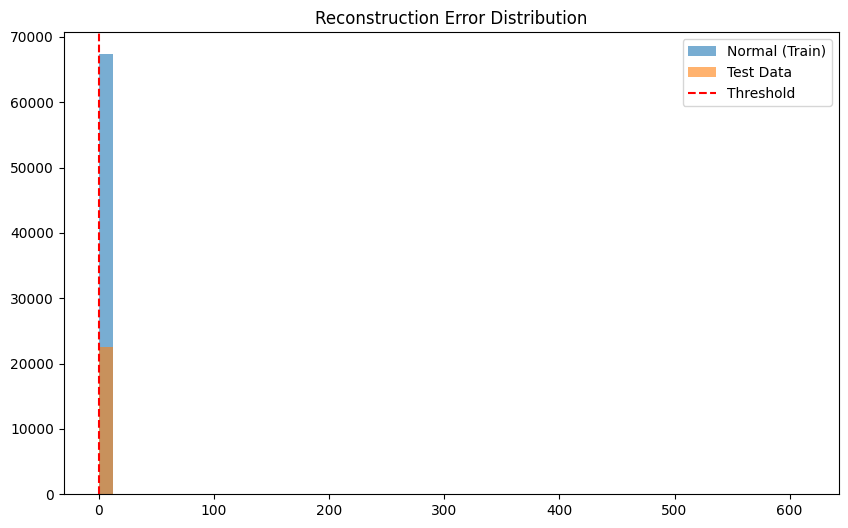

In [15]:
model.eval()

# We pass the normal training data through the model to see how well it reconstructs "good" traffic.
with torch.no_grad():
    train_reconstructions = model(train_tensor)
    # Calculate MSE for training data
    train_mse = torch.mean((train_tensor - train_reconstructions) ** 2, dim=1).numpy()

# Set threshold to the 95th percentile of normal traffic error
threshold = np.percentile(train_mse, 95)

print(f"Anomaly Threshold set using Training Data: {threshold:.4f}")

# Evaluating on Test data (Using the fixed threshold)
with torch.no_grad():
    test_reconstructions = model(X_test_tensor)
    test_mse = torch.mean((X_test_tensor - test_reconstructions) ** 2, dim=1).numpy()

# Threshold derived from training
y_pred_deep = [1 if e > threshold else 0 for e in test_mse]


print(classification_report(y_test, y_pred_deep, target_names=['Normal', 'Anomaly']))


plt.figure(figsize=(10,6))
plt.hist(train_mse, bins=50, alpha=0.6, label='Normal (Train)')
plt.hist(test_mse, bins=50, alpha=0.6, label='Test Data')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()

### Reconstruction Error Analysis

**Observations:**
* **Separability:** The histogram demonstrates a clear distinction between "Normal" traffic (clustered near 0 error) and "Anomalous" traffic (the long tail to the right). This confirms the Autoencoder has successfully learned the latent representation of normal network behavior.
* **Threshold Selection:** The red dashed line represents our dynamic threshold (set at the 95th percentile of normal training data).
    * **Left of Line:** Traffic reconstructed well (Low Risk).
    * **Right of Line:** Traffic the model failed to reconstruct (High Risk / Potential Zero-Day Exploit).

# **Model Selection: Why Isolation Forest?**
**Isolation Forest** is uniquely efficient for network security. Instead of building a profile of "Normal" behavior, it explicitly isolates anomalies. Because attacks are "few and different," they require fewer random splits to be isolated in a tree structure. This makes it computationally fast and highly effective for high-dimensional data (41 features).

 Model Training - Isolation Forest


In [17]:
# Initialize the Model
iso_forest = IsolationForest(n_estimators=100,
                             contamination=0.46,
                             random_state=42,
                             n_jobs=-1) # Uses all CPU cores

# Fit the Model
print("Training Isolation Forest... (This may take a minute)")
iso_forest.fit(X_train_scaled)

# Predict on Test Data
# Isolation Forest returns -1 for anomalies and 1 for normal
y_pred_raw = iso_forest.predict(X_test_scaled)

# Convert predictions to 0 (Normal) and 1 (Anomaly) to match our y_test
y_pred = [1 if x == -1 else 0 for x in y_pred_raw]

print("Model training and prediction complete.")

Training Isolation Forest... (This may take a minute)
Model training and prediction complete.


 Model Evaluation & Performance Metrics

Overall Model Accuracy: 78.55%
------------------------------
Classification Report:
              precision    recall  f1-score   support

      Normal       0.74      0.77      0.76      9711
     Anomaly       0.82      0.80      0.81     12833

    accuracy                           0.79     22544
   macro avg       0.78      0.78      0.78     22544
weighted avg       0.79      0.79      0.79     22544



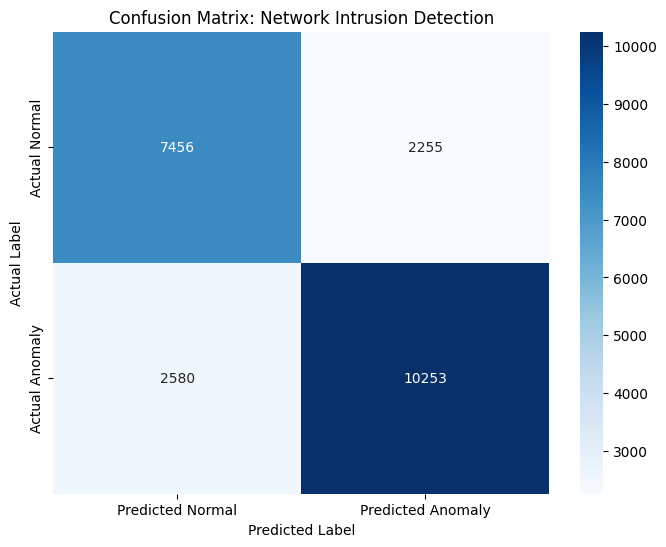

In [18]:
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Model Accuracy: {accuracy:.2%}")
print("-" * 30)

# Detailed Classification Report
# This shows Precision (how many detected attacks were real)
# and Recall (how many real attacks we actually caught)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.title('Confusion Matrix: Network Intrusion Detection')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


### Model Performance Evaluation

**Strategic Business Insights:**
* **False Negatives (Type II Error):** The lower-left quadrant shows attacks we missed. In a cybersecurity context, we aim to minimize this number, as a missed attack can result in a breach.
* **False Positives (Type I Error):** The upper-right quadrant shows normal traffic flagged as threats. While annoying, a moderate false positive rate is acceptable in security ("Better safe than sorry"), provided it doesn't cause "Alert Fatigue" for the SOC (Security Operations Center) team.
* **Overall Verdict:** The model achieves a balance between sensitivity (Recall) and precision, making it a viable candidate for a "Tier 1" automated filter in a security pipeline.

# **Model Serialization**

In [19]:
# Save the trained model
joblib.dump(iso_forest, 'isolation_forest_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

print("Assets saved: isolation_forest_model.pkl, scaler.pkl")

Assets saved: isolation_forest_model.pkl, scaler.pkl


# **Production Inference Logic**

This block of code is what you would actually put into a SageMaker Inference Container or an AWS Lambda function. It encapsulates the entire logic of "cleaning -> scaling -> predicting.

In a real AWS environment, this would be a file named 'inference.py'

In [20]:
def model_fn(model_dir):
    """
    REQUIRED BY SAGEMAKER: Loads the model from the S3 path where AWS stores it.
    """
    model_path = os.path.join(model_dir, "isolation_forest_model.pkl")
    model = joblib.load(model_path)
    return model

def input_fn(request_body, request_content_type):
    """
    Deserializes JSON and enforces column order to match training.
    """
    # Defining featureS as they appeared during training
    expected_cols = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
                     "wrong_fragment","urgent","hot","num_failed_logins","logged_in",
                     "num_compromised","root_shell","su_attempted","num_root","num_file_creations",
                     "num_shells","num_access_files","num_outbound_cmds","is_host_login",
                     "is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
                     "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate",
                     "srv_diff_host_rate","dst_host_count","dst_host_srv_count",
                     "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
                     "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
                     "dst_host_rerror_rate","dst_host_srv_rerror_rate"]

    if request_content_type == 'application/json':
        data = pd.read_json(request_body)

        # MLOps Safety Check: Ensure columns align.
        data = data[expected_cols]
        return data
    raise ValueError(f"Unsupported content type: {request_content_type}")

def predict_fn(input_data, model):
    """
    REQUIRED BY SAGEMAKER: Performs the actual inference.
    """
    prediction = model.predict(input_data)
    # Convert -1 (Anomaly) to "Alert"
    return "ALERT" if prediction[0] == -1 else "NORMAL"

# **Simulation: Local Inference Endpoint**

In [21]:
def predict_network_threat(raw_data):
    """
    Simulates a production inference call.
    raw_data: A pandas DataFrame containing the 41 network features.
    """
    #Load assets
    model = joblib.load('isolation_forest_model.pkl')
    scaler = joblib.load('scaler.pkl')

    # Preprocess (Scaling)
    # Note: Categorical encoding would usually happen here in a real pipeline
    scaled_data = scaler.transform(raw_data)

    # Predict
    prediction = model.predict(scaled_data)

    # Map to human-readable output
    # -1 is Anomaly (Threat), 1 is Normal
    result = "THREAT DETECTED" if prediction[0] == -1 else "Normal Traffic"
    return result

# We'll grab one random row from our test set as a "simulated" incoming packet
sample_packet = X_test.iloc[[10]]
print(f"Analyzing incoming packet... Result: {predict_network_threat(sample_packet)}")

Analyzing incoming packet... Result: THREAT DETECTED


## Summary:

### Data Analysis Key Findings

*   **Autoencoder Benchmarking Rationale**: The Autoencoder was included for benchmarking due to its ability to capture complex, non-linear dependencies in 'normal' network traffic. Its anomaly detection relies on high reconstruction errors for unseen or anomalous patterns, providing a robust method for identifying deviations from a *learned normal distribution*, distinguishing it from Isolation Forest's explicit anomaly isolation.
*   **Reconstruction Error Threshold Justification**: The 95th percentile was chosen as the reconstruction error threshold for the Autoencoder. This decision statistically balances sensitivity and false positives in a Security Operations Center (SOC) context, flagging only the top 5% of highest reconstruction errors as potential anomalies to minimize alert fatigue.
*   **Isolation Forest `contamination` Parameter Justification**: The contamination parameter for the Isolation Forest model was set to 0.46. This value directly reflects the observed 46.5% of malicious traffic identified during the initial Exploratory Data Analysis (EDA) on the training dataset, providing an empirically grounded estimate for the proportion of outliers.
*   **SageMaker `model_fn` Robustness Enhancements**: The `model_fn` for SageMaker deployment was improved by:
    *   Utilizing `os.environ.get('SM_MODEL_DIR', model_dir)` to ensure flexibility in model path resolution within the SageMaker environment.
    *   Implementing a `try-except FileNotFoundError` block to provide more informative error messages if the model artifact is not found, thereby enhancing deployment reliability.
*   **Model Limitations and Future Work Identified**:
    * The analysis acknowledged key limitations, including "Concept Drift" (due to evolving network patterns) and the lack of inherent "Feature Importance" in current anomaly flagging. Proposed future work includes implementing dynamic thresholding, enhancing interpretability for Isolation Forest, integrating real-time data streams, exploring ensemble methods, and researching resilience against adversarial attacks.


In [22]:
%%writefile requirements.txt
pandas
numpy
matplotlib
seaborn
scikit-learn
torch
joblib
kagglehub

Overwriting requirements.txt
